In [4]:
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 3.5 MB/s eta 0:00:00a 0:00:01


# Analyse the data

/var/folders/14/rv2z3xhs7yd8y86zz9spbklw0000gn/T/ipykernel_16447/3198258738.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


               m.p0
m.ts               
2023-02-09    82698
2023-02-10    62961
2023-02-11    35067
2023-02-12    31298
2023-02-13    67758
...             ...
2023-05-29  2985398
2023-05-30  2852102
2023-05-31  3179655
2023-06-01  3024879
2023-06-02   400576

[114 rows x 1 columns]


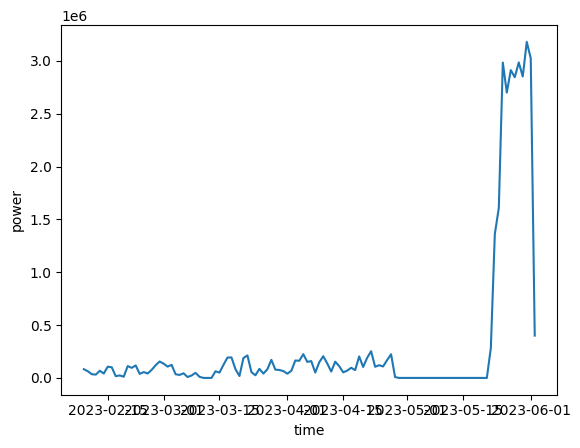

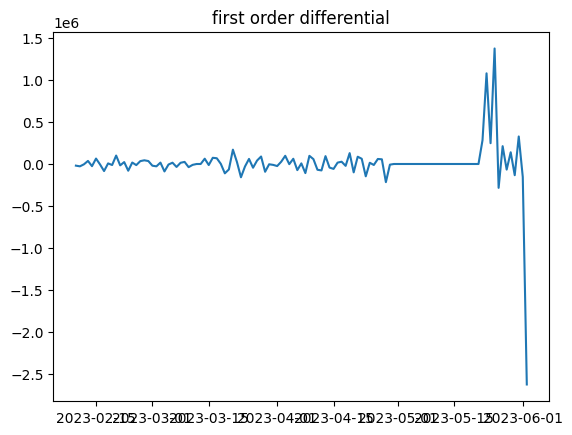

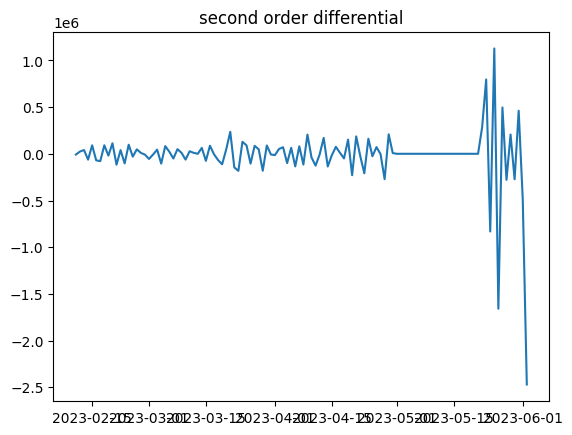

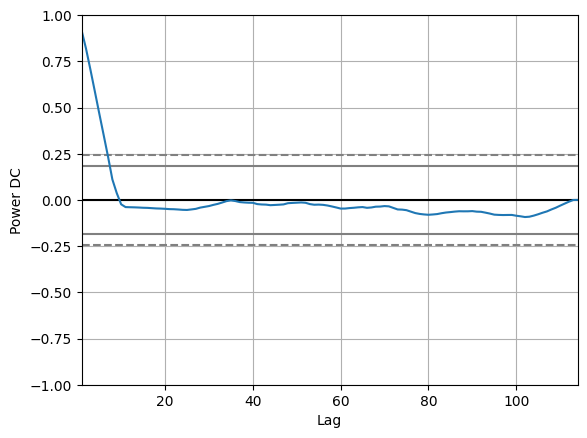

In [87]:
import pandas as pd
from pandas import datetime
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot

def parser(date_string):
    return datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%S.%fZ")
series = pd.read_csv("inverters_unwind.csv", parse_dates=["m.ts"], date_parser=parser)

power = series[['m.ts','m.p0']]
power.set_index('m.ts', inplace=True)
power = power.resample('D').sum()
print(power)
plt.plot(power)
plt.xlabel("time")
plt.ylabel("power")
plt.show()
#date= "2023-03"
#filter_df=power.loc[date]
#print(filter_df.head())
#plt.plot(filter_df["m.p0"])
#plt.xlabel("Time")
#plt.ylabel("Power DC")
#plt.title("without correlation")
#plt.show()
#to let all data have a common mean, we can check the diffrenciation 
diff1=power.diff(1)
plt.plot(diff1)
plt.title("first order differential")
plt.show()

diff2=diff1.diff(1)
plt.plot(diff2)
plt.title("second order differential")
plt.show()

autocorrelation_plot(power)
plt.xlabel("Lag")
plt.ylabel("Power DC")
plt.show()



## Stationary
**adfuller** is a common statistical test used to check if a time series is stationary or not. 

+ result[0]: **ADF Statistic**<br>
    This is the result of the test.More negative values indicate stronger evidence against the null hypothesis of the ADF test (the null hypothesis being that the time series has a unit root and is non-stationary).
    
+ result[1]: **p-value**<br>
    The p-value associated with the ADF statistic. If this p-value is small (commonly less than 0.05), it means you have strong evidence to reject the null hypothesis and conclude that your series is stationary.

+ result[2]: **Number of lags used**<br>
    This is the number of lags considered in the test, determined by the test itself based on the data size.
                     
+ result[3]: **Number of observations used for the ADF regression and critical values estimation**<br>
    This is essentially the size of your sample after considering the lags.

+ result[4]: **Critical values**<br>
    These are the test statistic values at which you would reject the null hypothesis, given the level of confidence you want to have in your result (commonly at 1%, 5% and 10% levels).


In [66]:
#statistic check
from statsmodels.tsa.stattools import adfuller

# Assuming you have a time series data stored in the variable 'data'
result = adfuller(power)

# Extract the ADF test statistic
adf_statistic = result[0]

# Extract the p-value
p_value = float(result[1])

# Extract critical values at different significance levels
critical_values = result[4]

# Print the results
print(f"ADF Statistic: {adf_statistic}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")
    
print(result[2])

ADF Statistic: -7.1852003340797
P-value: 2.5876783930318747e-10
Critical Values:
	1%: -3.4948504603223145
	5%: -2.889758398668639
	10%: -2.5818220155325444
9


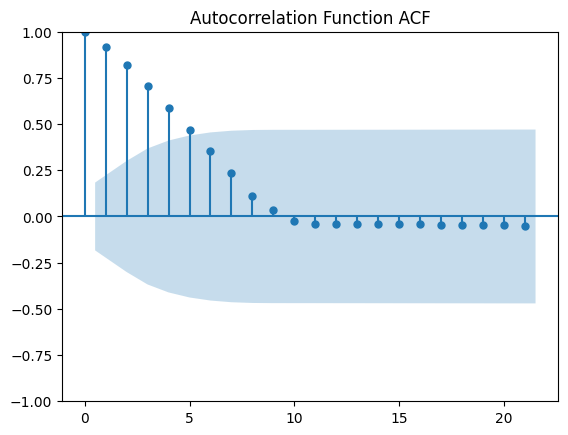

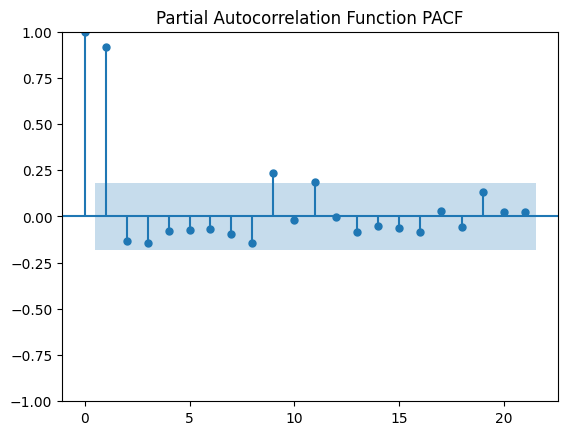

In [144]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
fig, ax = plt.subplots()
plot_acf(power, ax=ax)
plt.title("Autocorrelation Function ACF")
plt.show()

plot_pacf(power)
plt.title("Partial Autocorrelation Function PACF")
plt.show()

# The Ljung-Box test checks if there is any significant autocorrelation present in the residuals. 
# In white noise, the test should not reject the null hypothesis of no autocorrelation. 
#lb_stat, lb_p_value = acorr_ljungbox(filter_df["m.p0"], lags=10)
#for lag, stat, p_value in zip(range(1, len(lb_stat)+1), lb_stat, lb_p_value):
#   print(f"Lag {lag}: Test Statistic = {stat:.4f}, p-value = {p_value:.4f}")


In [132]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(power, order=(2,2,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   m.p0   No. Observations:                  114
Model:                 ARIMA(2, 2, 0)   Log Likelihood               -1576.630
Date:                Sun, 18 Jun 2023   AIC                           3159.260
Time:                        16:14:39   BIC                           3167.415
Sample:                    02-09-2023   HQIC                          3162.569
                         - 06-02-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6549      0.172     -3.810      0.000      -0.992      -0.318
ar.L2         -0.1606      0.200     -0.804      0.422      -0.552       0.231
sigma2      1.005e+11   5.72e-12   1.76e+22      0.0

## Residuals
**Residuals** in an ARIMA model are the differences between the observed values and the values predicted by the model.

+ **Count**: The total number of residuals, which should be equal to the number of data points minus the number of parameters estimated by the model.
+ **Mean**: This is the average residual, which ideally should be close to zero. If the mean is not zero, it may suggest that your model is systematically underestimating or overestimating the values.
+ **Min/Max**: These are the minimum and maximum residual values. Extremely large or small values could suggest outliers or that the model is failing to capture some aspect of the data.
+ **Standard deviation (std)**: This is a measure of the variability of the residuals. If this value is large, it could suggest that your model is not capturing all of the variability in the data.

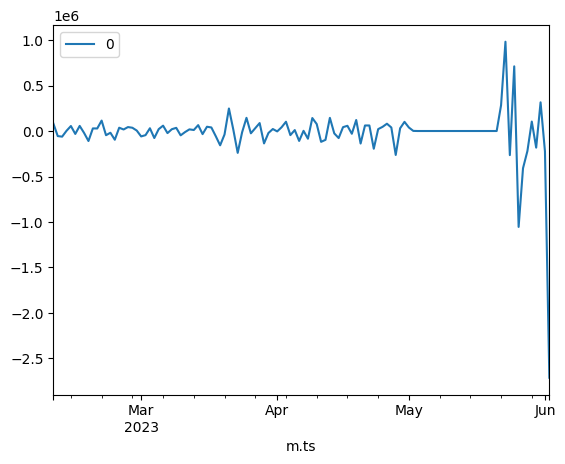

In [133]:
#plot residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

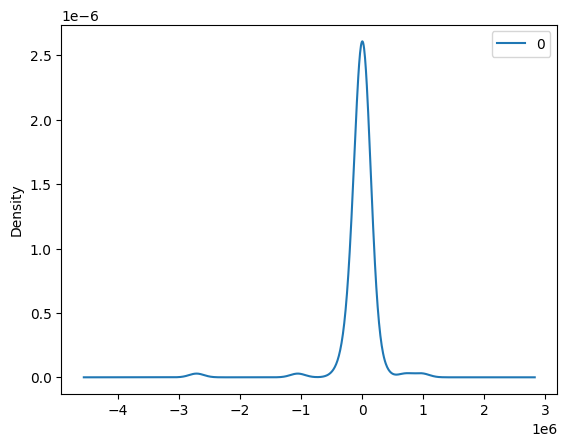

                  0
count  1.140000e+02
mean  -2.351350e+04
std    3.121340e+05
min   -2.711361e+06
25%   -4.340453e+04
50%    8.770617e-46
75%    4.074794e+04
max    9.812753e+05


In [134]:
#density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

# Forecast ARIMA Model
To use ARIMA to make predicions, it accepts the index of the time steps to make predictions as arguments. The data should use as the trainning dataset(e.g. 100 observations) to fit the model and use the **predict( )** function with start=101, end=101. This would return an array with one element containing the predictions. And to let the predicted value be in the original scale, the *typ* argument should be set as *levels*

An alternative way to do prediction is **forcast( )** function, a one-step forecast model. The dataset should be split as training as test dataset, where training dataset is used to fit the model and generate a prediction for each element on the test set.

In [136]:

X = power["m.p0"].values
#training data size
size = int(len(X)*0.66)
train, test = X[:size], X[size:len(X)]
history = [x for x in train]

prediction = []
#walk-forward validation
for t in range(len(test)):
    model= ARIMA(history, order=(2,2,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    prediction.append(yhat)
    obs = test[t]
    history.append(obs)
    print("predicted:%f, expected:%f"%(yhat, obs))


predicted:127683.347807, expected:108632.000000
predicted:33201.391368, expected:168343.000000
predicted:190320.842092, expected:224062.000000
predicted:248612.675074, expected:7826.000000
predicted:-12381.442771, expected:0.000000
predicted:-19528.855632, expected:0.000000
predicted:-112580.961609, expected:0.000000
predicted:-3731.305271, expected:0.000000
predicted:0.000000, expected:0.000000
predicted:-0.000000, expected:0.000000
predicted:0.000000, expected:0.000000
predicted:-0.000000, expected:0.000000
predicted:-0.000000, expected:0.000000
predicted:0.000000, expected:0.000000
predicted:-0.000000, expected:0.000000
predicted:0.000000, expected:0.000000
predicted:-0.000000, expected:0.000000
predicted:-0.000000, expected:0.000000
predicted:0.000000, expected:0.000000
predicted:-0.000000, expected:0.000000
predicted:-0.000000, expected:0.000000
predicted:-0.000000, expected:0.000000
predicted:0.000000, expected:0.000000
predicted:0.000000, expected:0.000000
predicted:0.000000, ex

Test RMSE: 566387.618


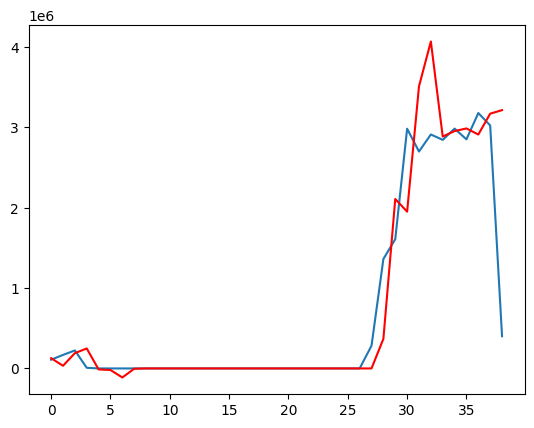

In [137]:
from sklearn.metrics import mean_squared_error
from math import sqrt
#root mean square error
rmse = sqrt(mean_squared_error(test, prediction))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(prediction, color='red')
plt.show()

# Seasonal ARIMA
Additional four seasonal elements:
    + **P**: seasonal Autoregressive order
    + **D**: seasonal difference order
    + **Q**: seasonal moving average order
    + **m**: the number of time steps for a single seasonal period

Along with ARIMA: 
    + *SARIMA(p,d,q)(P,D,Q)m*
    
The *m* parameter influences the *P, D* and *Q*. 

**For Example:**
    $m=12$ for monthly data suggests a yearly seasonal cycle.
    
$P=1$ would would make the first seasonally offset observation in the model 

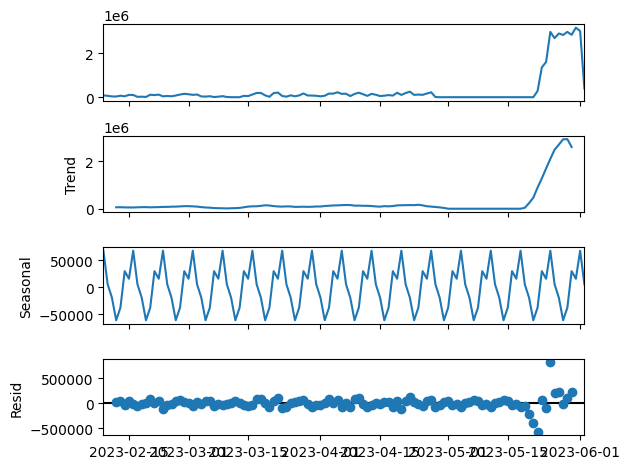

In [142]:
# Check the trend and seasonal components of the data
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(power, model='additive')
decomposition.plot()
plt.show()

In [156]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in pdq]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(
                            power,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False
                        )
            results = mod.fit()
            AIC = results.aic
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, AIC))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24001D+01    |proj g|=  3.94528D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.945D-07   1.240D+01
  F =   12.400091623021860     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2829.220890048984
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.62209D+00    |proj g|=  6.61818D-04

At iterate   10    f=  9.62202D+00    |proj g|=  2.63896D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     29      1     0     0   7.817D-06   9.622D+00
  F =   9.6220175897224411     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:2199.820010456717
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10735D+01    |proj g|=  2.28795D-07

           * *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.09639D+01    |proj g|=  2.82661D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   1.472D-06   1.096D+01
  F =   10.963862142622244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:2505.7605685178714
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.63541D+00    |proj g|=  4.67862D-02


 This problem is unconstrained.



At iterate    5    f=  9.62450D+00    |proj g|=  6.68186D-03

At iterate   10    f=  9.62127D+00    |proj g|=  7.72012D-04

At iterate   15    f=  9.62125D+00    |proj g|=  7.28608D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     21      1     0     0   7.286D-06   9.621D+00
  F =   9.6212501245703361     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:2201.6450284020366
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:2202.110908010364
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62480D+00    |proj g|=  3.28475D-02


 This problem is unconstrained.



At iterate    5    f=  9.61113D+00    |proj g|=  5.63854D-04

At iterate   10    f=  9.61112D+00    |proj g|=  1.15190D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   6.913D-06   9.611D+00
  F =   9.6111217030782328     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:2201.335748301837
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22740D+01    |proj g|=  5.02526D-03

           * *

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08311D+01    |proj g|=  1.87950D-02

At iterate    5    f=  1.08229D+01    |proj g|=  2.39204D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      9      1     0     0   2.392D-06   1.082D+01
  F =   10.822864586292075     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2473.613125674593
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

 This problem is unconstrained.



At iterate    5    f=  9.40272D+00    |proj g|=  1.01339D-01

At iterate   10    f=  9.38708D+00    |proj g|=  6.54466D-03

At iterate   15    f=  9.38454D+00    |proj g|=  1.12819D-02

At iterate   20    f=  9.38387D+00    |proj g|=  1.65909D-04
  ys=-6.047E-05  -gs= 2.640E-05 BFGS update SKIPPED

At iterate   25    f=  9.37948D+00    |proj g|=  1.64727D-02

At iterate   30    f=  9.37782D+00    |proj g|=  8.82688D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     50      1     1     0   9.607D-06   9.378D+00
  F =   9.3778230644711975     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.08226D+01    |proj g|=  3.24649D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   4.067D-06   1.082D+01
  F =   10.822339000213018     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:2475.493292048568
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43605D+00    |proj g|=  1.63757D-01


 This problem is unconstrained.



At iterate    5    f=  9.39105D+00    |proj g|=  4.36230D-02

At iterate   10    f=  9.38049D+00    |proj g|=  4.12083D-03

At iterate   15    f=  9.38045D+00    |proj g|=  1.12706D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     21      1     0     0   1.127D-05   9.380D+00
  F =   9.3804492594393523     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 - AIC:2148.7424311521722
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.62286D+00    |proj g|=  7.69314D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     10      1     0     0   9.603D-07   9.623D+00
  F =   9.6228619380701925     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:2202.012521880004
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62098D+00    |proj g|=  2.09116D-02

At iterate    5    f=  9.61835D+00    |proj g|=  9.80119D-05

           * *

 This problem is unconstrained.



At iterate    5    f=  9.36386D+00    |proj g|=  4.34379D-03

At iterate   10    f=  9.36358D+00    |proj g|=  2.82078D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     14      1     0     0   9.582D-07   9.364D+00
  F =   9.3635786670769079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 2, 12)12 - AIC:2146.895936093535
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21470D+01    |proj g|=  1.85137D-02

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:2442.0673966730064
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32856D+00    |proj g|=  2.11684D-01

At iterate    5    f=  9.27155D+00    |proj g|=  7.73483D-02


 This problem is unconstrained.



At iterate   10    f=  9.24304D+00    |proj g|=  3.46743D-02

At iterate   15    f=  9.23804D+00    |proj g|=  5.97313D-03

At iterate   20    f=  9.23388D+00    |proj g|=  2.33380D-03

At iterate   25    f=  9.23146D+00    |proj g|=  1.73246D-02

At iterate   30    f=  9.23117D+00    |proj g|=  5.22904D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     53      1     0     0   5.774D-06   9.231D+00
  F =   9.2311726008530748     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:2114.707352994501
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.06756D+01    |proj g|=  1.77780D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   7.621D-06   1.068D+01
  F =   10.675571413940130     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:2444.0302823783495
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31377D+00    |proj g|=  1.87591D-01

At iterate    5    f=  9.26475D+00    |proj g|=  4.35717D-02


 This problem is unconstrained.



At iterate   10    f=  9.23971D+00    |proj g|=  2.00895D-02

At iterate   15    f=  9.23800D+00    |proj g|=  1.75268D-03

At iterate   20    f=  9.23721D+00    |proj g|=  7.04448D-03

At iterate   25    f=  9.23710D+00    |proj g|=  4.94968D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     34      1     0     0   4.498D-07   9.237D+00
  F =   9.2371028607399541     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:2118.0594522487095
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  9.58564D+00    |proj g|=  1.92714D-02

At iterate   10    f=  9.58428D+00    |proj g|=  3.19103D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     26      1     0     0   2.503D-05   9.584D+00
  F =   9.5842820798177915     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:2195.2163141984565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.60994D+00    |proj g|=  1.95330D-02


 This problem is unconstrained.



At iterate    5    f=  9.58410D+00    |proj g|=  2.19528D-02

At iterate   10    f=  9.58185D+00    |proj g|=  3.16210D-03

At iterate   15    f=  9.58182D+00    |proj g|=  1.33964D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     21      1     0     0   1.340D-05   9.582D+00
  F =   9.5818160986537197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:2196.654070493048
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  9.22320D+00    |proj g|=  9.76671D-02

At iterate   10    f=  9.20627D+00    |proj g|=  2.70701D-02

At iterate   15    f=  9.20281D+00    |proj g|=  9.48822D-03

At iterate   20    f=  9.20278D+00    |proj g|=  1.43679D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     32      1     0     0   1.329D-05   9.203D+00
  F =   9.2027753238862342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:2112.2327738460613
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:2829.504015932918
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision =

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.254D-07   1.094D+01
  F =   10.941428926617482     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:2500.6457952687856
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.57383D+00    |proj g|=  1.93375D-01


 This problem is unconstrained.



At iterate    5    f=  9.51940D+00    |proj g|=  7.70613D-02

At iterate   10    f=  9.50730D+00    |proj g|=  6.41129D-03

At iterate   15    f=  9.50379D+00    |proj g|=  1.97655D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   2.462D-06   9.504D+00
  F =   9.5037700226994541     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:2174.8595651754754
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56071D+00    |proj g|=  1.72638D-01

At iterate    5    f=  9.51053D+00    |proj g|=  4.94679D-02

At iterate   10    f=  9.50026D+00    |proj g|=  6.42724D-03

At iterate   15    f=  9.49991D+00    |proj g|=  3.83734D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   3.837D-05   9.500D+00
  F =   9.4999146408843629     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1,

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:2174.744204993859
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50209D+00    |proj g|=  2.68991D-02

At iterate    5    f=  9.49831D+00    |proj g|=  1.90224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   2.503D-06   9.498D+00
  F =   9.4983100321839178     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:2175.6146873379334
RUNNING THE L-BFGS-B 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     14      1     0     0   8.633D-07   9.484D+00
  F =   9.4836736401114621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(2, 1, 2, 12)12 - AIC:2174.277589945413
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22714D+01    |proj g|=  3.51586D-02

At iterate    5    f=  1.22695D+01    |proj g|=  1.61063D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.08177D+01    |proj g|=  5.08799D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   1.004D-06   1.082D+01
  F =   10.817702964505351     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:2474.43627590722
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44717D+00    |proj g|=  1.86833D-01


 This problem is unconstrained.



At iterate    5    f=  9.40340D+00    |proj g|=  3.10321D-02

At iterate   10    f=  9.38514D+00    |proj g|=  7.19838D-03

At iterate   15    f=  9.38069D+00    |proj g|=  7.38137D-03

At iterate   20    f=  9.37775D+00    |proj g|=  4.00930D-02

At iterate   25    f=  9.37373D+00    |proj g|=  3.93117D-03

At iterate   30    f=  9.37364D+00    |proj g|=  4.30766D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     45      1     0     0   4.308D-07   9.374D+00
  F =   9.3736367958531055     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:2147.189189454

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:2476.3046332744702
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43452D+00    |proj g|=  1.65901D-01



 This problem is unconstrained.


At iterate    5    f=  9.38932D+00    |proj g|=  4.16760D-02

At iterate   10    f=  9.37747D+00    |proj g|=  8.55452D-03

At iterate   15    f=  9.37684D+00    |proj g|=  1.43787D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   3.818D-05   9.377D+00
  F =   9.3768426995790790     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 2, 12)12 - AIC:2149.92013550403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.


ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:2175.641411528664
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50078D+00    |proj g|=  5.38285D-02

At iterate    5    f=  9.49422D+00    |proj g|=  3.18433D-03

At iterate   10    f=  9.49418D+00    |proj g|=  6.12435D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     12      1     0     0   6.124D-06   9.494D+00
  F =   9.4941798252353422     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:2176.673000153658
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40556D+00    |proj g|=  1.07925D-01


 This problem is unconstrained.



At iterate    5    f=  9.35941D+00    |proj g|=  3.54007D-03

At iterate   10    f=  9.35910D+00    |proj g|=  9.14543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     16      1     0     0   2.712D-06   9.359D+00
  F =   9.3590994565538690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:2147.874676094282
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21450D+01    |proj g|=  1.38424D-02

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     19      1     0     0   9.477D-07   1.067D+01
  F =   10.674226417045864     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:2443.723623086457
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32237D+00    |proj g|=  1.98040D-01

At iterate    5    f=  9.27131D+00    |proj g|=  6.45980D-02


 This problem is unconstrained.



At iterate   10    f=  9.23976D+00    |proj g|=  4.76680D-02

At iterate   15    f=  9.23589D+00    |proj g|=  1.12478D-02

At iterate   20    f=  9.23143D+00    |proj g|=  5.52285D-03

At iterate   25    f=  9.22570D+00    |proj g|=  4.36771D-02

At iterate   30    f=  9.22237D+00    |proj g|=  8.84956D-03

At iterate   35    f=  9.22226D+00    |proj g|=  1.76483D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     50      1     0     0   1.765D-05   9.222D+00
  F =   9.2222585445898613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 2, 12)12 - AIC:2114.674948166

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.09331D+01    |proj g|=  4.51660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     17      1     0     0   1.165D-05   1.093D+01
  F =   10.932862123136511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:2502.6925640751247
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06993D+01    |proj g|=  1.89108D-02

At iterate    5    f=  1.06747D+01    |proj g|=  8.29703D-03

At iterate   

 This problem is unconstrained.



At iterate   10    f=  9.23676D+00    |proj g|=  1.13872D-02

At iterate   15    f=  9.23631D+00    |proj g|=  1.96018D-03

At iterate   20    f=  9.23630D+00    |proj g|=  1.96557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     26      1     0     0   3.064D-05   9.236D+00
  F =   9.2362988683742770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:2119.8761419893353
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   10    f=  9.45910D+00    |proj g|=  3.68448D-03

At iterate   15    f=  9.45900D+00    |proj g|=  3.98105D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     22      1     0     0   3.981D-05   9.459D+00
  F =   9.4590043743774963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:2168.652997358069
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49035D+00    |proj g|=  3.33385D-02

At iterate    

 This problem is unconstrained.



At iterate   10    f=  9.45353D+00    |proj g|=  1.25025D-02

At iterate   15    f=  9.45313D+00    |proj g|=  2.15766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     22      1     0     0   1.319D-05   9.453D+00
  F =   9.4531258267101084     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:2169.3126884899048


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27754D+00    |proj g|=  1.17201D-01

At iterate    5    f=  9.22252D+00    |proj g|=  8.81759D-02

At iterate   10    f=  9.20572D+00    |proj g|=  1.25155D-01

At iterate   15    f=  9.20086D+00    |proj g|=  2.18061D-02

At iterate   20    f=  9.19735D+00    |proj g|=  2.16856D-03

At iterate   25    f=  9.19732D+00    |proj g|=  4.09541D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     39      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   5.227D-06   1.093D+01
  F =   10.934366521482628     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:2501.035566898039
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.57240D+00    |proj g|=  2.10773D-01


 This problem is unconstrained.



At iterate    5    f=  9.51263D+00    |proj g|=  5.06113D-02

At iterate   10    f=  9.50017D+00    |proj g|=  2.37184D-03

At iterate   15    f=  9.49917D+00    |proj g|=  2.94020D-03

At iterate   20    f=  9.49913D+00    |proj g|=  3.33491D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     30      1     0     0   1.367D-06   9.499D+00
  F =   9.4991266174180762     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:2175.8008687713213
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.55749D+00    |proj g|=  1.85957D-01

At iterate    5    f=  9.50708D+00    |proj g|=  4.21903D-02

At iterate   10    f=  9.49743D+00    |proj g|=  5.51844D-03


 This problem is unconstrained.



At iterate   15    f=  9.49690D+00    |proj g|=  7.50177D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     20      1     0     0   7.638D-06   9.497D+00
  F =   9.4969036620063410     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:2177.2940349374458
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37891D+00    |proj g|=  2.32271D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.37787D+00    |proj g|=  4.03268D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   7.241D-06   9.378D+00
  F =   9.3778710910089593     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:2148.154608750043
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37638D+00    |proj g|=  2.42465D-02

At iterate    5    f=  9.37364D+00    |proj g|=  8.00955D-04

           * *

 This problem is unconstrained.


At iterate   10    f=  9.35683D+00    |proj g|=  1.22753D-03

At iterate   15    f=  9.35630D+00    |proj g|=  1.65542D-03

At iterate   20    f=  9.35628D+00    |proj g|=  3.39163D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     23      1     0     0   3.392D-05   9.356D+00
  F =   9.3562784247427420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:2147.2314808413453
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44826D+00    |proj g|=  2.04265D-01

At iterate    5    f=  9.38970D+00    |proj g|=  7.72693D-02


 This problem is unconstrained.



At iterate   10    f=  9.37891D+00    |proj g|=  4.96711D-03

At iterate   15    f=  9.37809D+00    |proj g|=  2.83477D-03

At iterate   20    f=  9.37734D+00    |proj g|=  3.86341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     28      1     0     0   1.423D-05   9.377D+00
  F =   9.3773392147728138     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:2150.0333409682016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.08242D+01    |proj g|=  3.54846D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   9.679D-06   1.082D+01
  F =   10.824170218962683     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:2477.910809923492
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08222D+01    |proj g|=  1.66408D-02

At iterate    5    f=  1.08144D+01    |proj g|=  8.08305D-03

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  9.37510D+00    |proj g|=  4.12797D-03

At iterate   15    f=  9.37483D+00    |proj g|=  1.19192D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     22      1     0     0   8.977D-06   9.375D+00
  F =   9.3748174285995507     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:2151.4583737206976
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37766D+00    |proj g|=  2.52725D-02

At iterate   

 This problem is unconstrained.



At iterate   10    f=  9.37614D+00    |proj g|=  1.44986D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     13      1     0     0   1.450D-06   9.376D+00
  F =   9.3761391937577603     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:2149.7597361767694
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37525D+00    |proj g|=  2.69184D-02

At iterate    5    f=  9.37191D+00    |proj g|=  2.81166D-03

At iterate   10    f=  9.37178D+00    |proj g|=  4.66056D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     18      1     0     0   2.823D-05   9.372D+00
  F =   9.3717795579327916     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:2150.7657392086767


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40202D+00    |proj g|=  1.18746D-01

At iterate    5    f=  9.35600D+00    |proj g|=  5.27374D-03

At iterate   10    f=  9.35562D+00    |proj g|=  1.05713D-03

At iterate   15    f=  9.35548D+00    |proj g|=  5.99783D-03

At iterate   20    f=  9.35374D+00    |proj g|=  7.62620D-03

At iterate   25    f=  9.34709D+00    |proj g|=  5.91474D-02

At iterate   30    f=  9.32309D+00    |proj g|=  1.09902D-01

At iterate   35    f=  9.31408D+00    |proj g|=  2.54589D-02

At iterate   40    f=  9.31250D+00    |proj g|=  1.88890D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.06504D+01    |proj g|=  1.68340D-02

At iterate   20    f=  1.06504D+01    |proj g|=  4.70486D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     25      1     0     0   4.705D-06   1.065D+01
  F =   10.650366302867932     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:2440.2835170538883
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31427D+00    |proj g|=  1.78098D-01


 This problem is unconstrained.



At iterate    5    f=  9.26499D+00    |proj g|=  1.39306D-01

At iterate   10    f=  9.22843D+00    |proj g|=  2.59069D-02

At iterate   15    f=  9.19734D+00    |proj g|=  1.01305D-01

At iterate   20    f=  9.16142D+00    |proj g|=  5.23083D-01

At iterate   25    f=  9.15667D+00    |proj g|=  9.15376D-02

At iterate   30    f=  9.15618D+00    |proj g|=  3.62934D-02

At iterate   35    f=  9.15606D+00    |proj g|=  2.13354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     80      1     0     0   2.134D-04   9.156D+00
  F =   9.1560638180647480     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.07861D+01    |proj g|=  3.93902D-02

At iterate   15    f=  1.07834D+01    |proj g|=  3.23683D-02

At iterate   20    f=  1.07827D+01    |proj g|=  6.66443D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     32      1     0     0   2.825D-05   1.078D+01
  F =   10.782684579262185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:2470.4520840717782
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   15    f=  1.06352D+01    |proj g|=  1.29996D-02

At iterate   20    f=  1.06333D+01    |proj g|=  1.05894D-02

At iterate   25    f=  1.06328D+01    |proj g|=  9.69085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     36      1     0     0   1.480D-05   1.063D+01
  F =   10.632780674612334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:2438.2739938116124
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  9.25160D+00    |proj g|=  8.33920D-02

At iterate   10    f=  9.22156D+00    |proj g|=  3.52691D-01

At iterate   15    f=  9.20291D+00    |proj g|=  8.84761D-02

At iterate   20    f=  9.20014D+00    |proj g|=  3.12694D-02

At iterate   25    f=  9.19986D+00    |proj g|=  7.33059D-03

At iterate   30    f=  9.19947D+00    |proj g|=  6.94133D-03

At iterate   35    f=  9.19944D+00    |proj g|=  2.26773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     53      1     0     0   3.406D-04   9.199D+00
  F =   9.1994410822021049     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  9.31228D+00    |proj g|=  3.27932D-01

At iterate   15    f=  9.29808D+00    |proj g|=  7.38458D-02

At iterate   20    f=  9.28171D+00    |proj g|=  1.05803D-01

At iterate   25    f=  9.28152D+00    |proj g|=  9.61833D-03

At iterate   30    f=  9.28137D+00    |proj g|=  5.94985D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     53      1     0     0   5.950D-05   9.281D+00
  F =   9.2813674114536990     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:2130.1517698114435
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f=  9.32497D+00    |proj g|=  3.81069D-02

At iterate   10    f=  9.31961D+00    |proj g|=  4.86879D-03

At iterate   15    f=  9.31817D+00    |proj g|=  4.41743D-02

At iterate   20    f=  9.30637D+00    |proj g|=  1.77186D-01

At iterate   25    f=  9.29650D+00    |proj g|=  1.27891D-01

At iterate   30    f=  9.28776D+00    |proj g|=  2.83561D-02

At iterate   35    f=  9.28245D+00    |proj g|=  3.82053D-02

At iterate   40    f=  9.28230D+00    |proj g|=  4.14854D-02

At iterate   45    f=  9.28188D+00    |proj g|=  3.78429D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.28181D+00    |proj g|=  1.05313D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   1.053D-02   9.282D+00
  F =   9.2818139350711348     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:2132.253577196219
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27126D+00    |proj g|=  1.09559D-01


 This problem is unconstrained.



At iterate    5    f=  9.19825D+00    |proj g|=  9.09583D-02

At iterate   10    f=  9.18164D+00    |proj g|=  2.81099D-02

At iterate   15    f=  9.17772D+00    |proj g|=  5.55621D-02

At iterate   20    f=  9.17401D+00    |proj g|=  4.04272D-01

At iterate   25    f=  9.15932D+00    |proj g|=  3.95257D-01

At iterate   30    f=  9.15249D+00    |proj g|=  3.71445D-01

At iterate   35    f=  9.15052D+00    |proj g|=  7.06984D-02

At iterate   40    f=  9.14762D+00    |proj g|=  2.40927D-01

At iterate   45    f=  9.14528D+00    |proj g|=  1.48817D-01

At iterate   50    f=  9.14446D+00    |proj g|=  1.81804D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21683D+01    |proj g|=  3.38676D-02

At iterate    5    f=  1.21569D+01    |proj g|=  4.96270D-03

At iterate   10    f=  1.21562D+01    |proj g|=  1.01027D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   1.570D-05   1.216D+01
  F =   12.156095483501687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
predicted:133897.074291, expected:108632.000000
RUNNING THE L-BFGS-B C


At iterate   10    f=  1.22248D+01    |proj g|=  1.59426D-03

At iterate   15    f=  1.22248D+01    |proj g|=  2.14728D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   2.147D-05   1.222D+01
  F =   12.224758776508322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
predicted:38960.963729, expected:0.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22255D+01    |proj g|=  1.28830D-02

At iterate    5    f=  1.22

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.21728D+01    |proj g|=  6.36611D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   1.423D-06   1.217D+01
  F =   12.172834997064539     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
predicted:1013.646512, expected:0.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21701D+01    |proj g|=  1.17088D-02

At iterate    5    f=  1.21690D+01    |proj g|=  5.05559D-04

At iterate   10    f=  1.216

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   1.513D-05   1.326D+01
  F =   13.258113069420588     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
predicted:2736706.757636, expected:2985398.000000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32665D+01    |proj g|=  1.78502D-02

At iterate    5    f=  1.32660D+01    |proj g|=  9.47048D-03

At iterate   10    f=  1.32659D+01    |proj g|=  5.73188D-05

           * * *

T

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


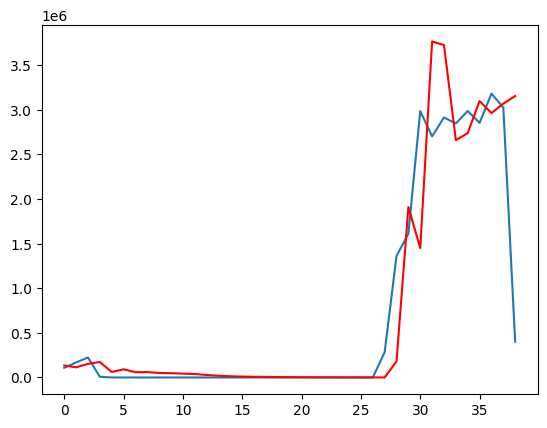

In [158]:

X = power["m.p0"].values
#training data size
size = int(len(X)*0.66)
train, test = X[:size], X[size:len(X)]
history = [x for x in train]

prediction = []
#walk-forward validation
for t in range(len(test)):
    model= SARIMAX(history, order=(2,1,2),seasonal=(0,1,2,12))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    prediction.append(yhat)
    obs = test[t]
    history.append(obs)
    print("predicted:%f, expected:%f"%(yhat, obs))
rmse = sqrt(mean_squared_error(test, prediction))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(prediction, color='red')
plt.show()